In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr-logos-27-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2173744%2F3629019%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T162505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D54ff767132e784716e17509b5aa6d6ecba376a95a0bb613a67783eccc44fd01f09bb4fcbb31e91ad8d4eb3ab9ae08f619ed0977f96074e78434a47e80a32e2c88e56951a0288bf3628d0085baaa7696b19888229136639f90f4ad0e65279c70c19820ef49b633cb5022cc94a4e1319a45529c70408a15659d26c408a9a92f6a0f2de9611736ec1ed0f11529dc8e55d2ac2a8ded11557c775cf9682175d93467c3cb7acedc64b10bc62fe8f4170fe42a3f63394f1717b0f1f09cedbb08db4469d170652d403763d9508531d71e37a05078f0db8ed084e057542f08d22765817cc98e2b94812b432ed0d338fc5a5be0518aaa33fb8116ae7f2c4fc82402341fe82'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 102013118 bytes downloaded
Downloaded and uncompressed: flickr-logos-27-dataset
Data source import complete.


In [2]:
# import the necessary packages
!pip install imutils
!pip install wget
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import wget
import cv2
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=56e722e6b83af99e3c96d1538a16d3c34f8af57ab7498b6142d372f63b7969bf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Downloading Dataset

In [3]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar.gz'

In [4]:
!ls

flickr_logos_27_dataset.tar.gz	sample_data


In [5]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

101827904/101827904 [==============================] - 22s 0us/step


In [6]:
import tarfile
fname = './flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [7]:
fname = './flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [8]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [11]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [12]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [13]:
dtdir = './flickr_logos_27_dataset_images/'

In [14]:
im = df[0][0]

In [15]:
size = df.iloc[:,3:]

In [16]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [17]:
img = os.path.join(dtdir,im)

In [18]:
size = size.values.tolist()

In [19]:
index=3
size[index][0],size[index][1],size[index][2],size[index][3]

(43, 122, 358, 354)

(210, 280, 3)

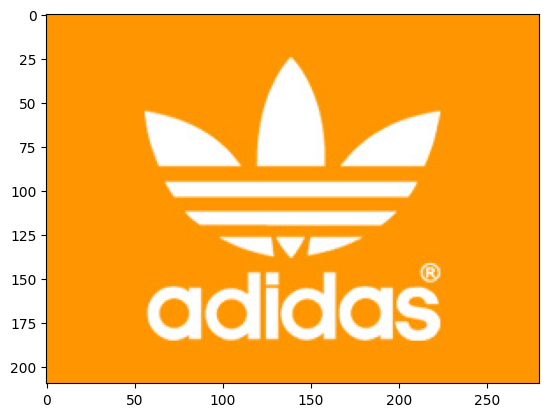

In [20]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

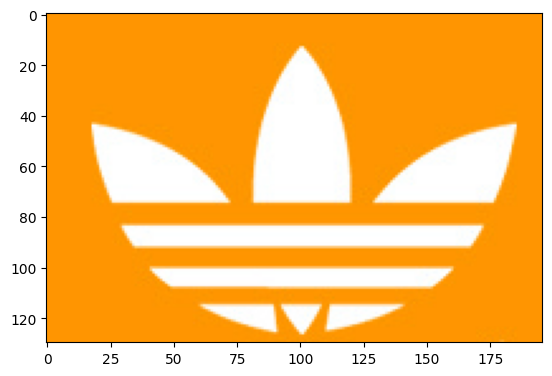

In [21]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [22]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [23]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

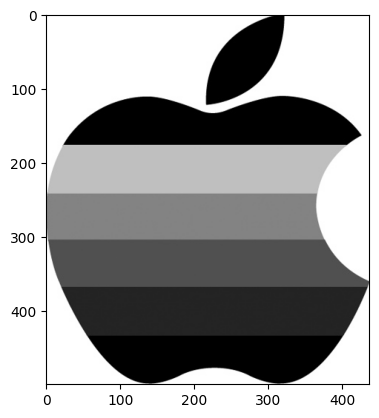

In [24]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
image.shape

In [25]:
testdist = 'TEST'

In [26]:
if not os.path.exists(testdist):
    os.makedirs(testdist)

In [27]:

y = list(set(list(Y)))
y.sort()

In [28]:
for i in y:
    os.makedirs(os.path.join(testdist,i))

In [29]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [30]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [31]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [32]:
HEIGHT = 224
WIDTH =  224

## Removing Corrupt Images

In [33]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

error
error
error
error
error


In [34]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [35]:
A

0      2403695909.jpg
1      2912587920.jpg
2      3441398196.jpg
3      4605630935.jpg
4      4606245138.jpg
            ...      
265    3480640208.jpg
266    3486224308.jpg
267    3486430785.jpg
268    3490185235.jpg
269    3490913574.jpg
Name: 0, Length: 270, dtype: object

In [36]:

for i in range(len(A)):
    try:
        destrain = os.path.join(testdist,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [37]:
imagePaths = list(paths.list_images(testdist))

TEST/Unicef/3646612994.jpg


(224, 224, 3)

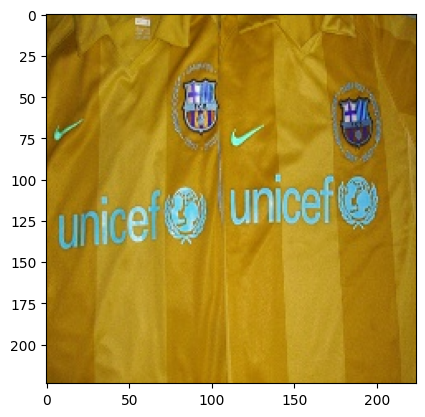

In [38]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
image.shape

## Image Augmentation

In [39]:
train = ImageDataGenerator(
rescale = 1/255,
horizontal_flip=True,
vertical_flip=True,
shear_range=0.2,
zoom_range=0.2,
featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
rotation_range=40, # Degree range for random rotations
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='nearest',
validation_split = 0.2)

In [40]:
imagePaths = list(paths.list_images(dest))

In [41]:
os.makedirs('preview')

In [42]:
img = load_img(imagePaths[50])  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='yh', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


## Samples Visualization

(224, 224, 3)

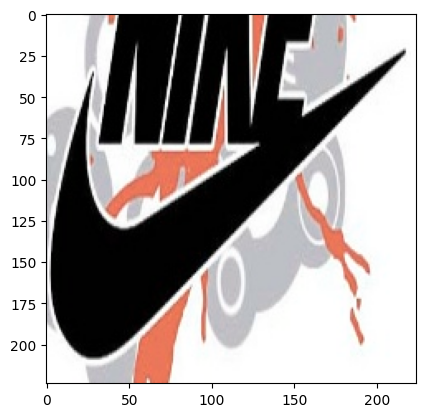

In [43]:
image = cv2.imread(imagePaths[50])
plt.imshow(image)
image.shape

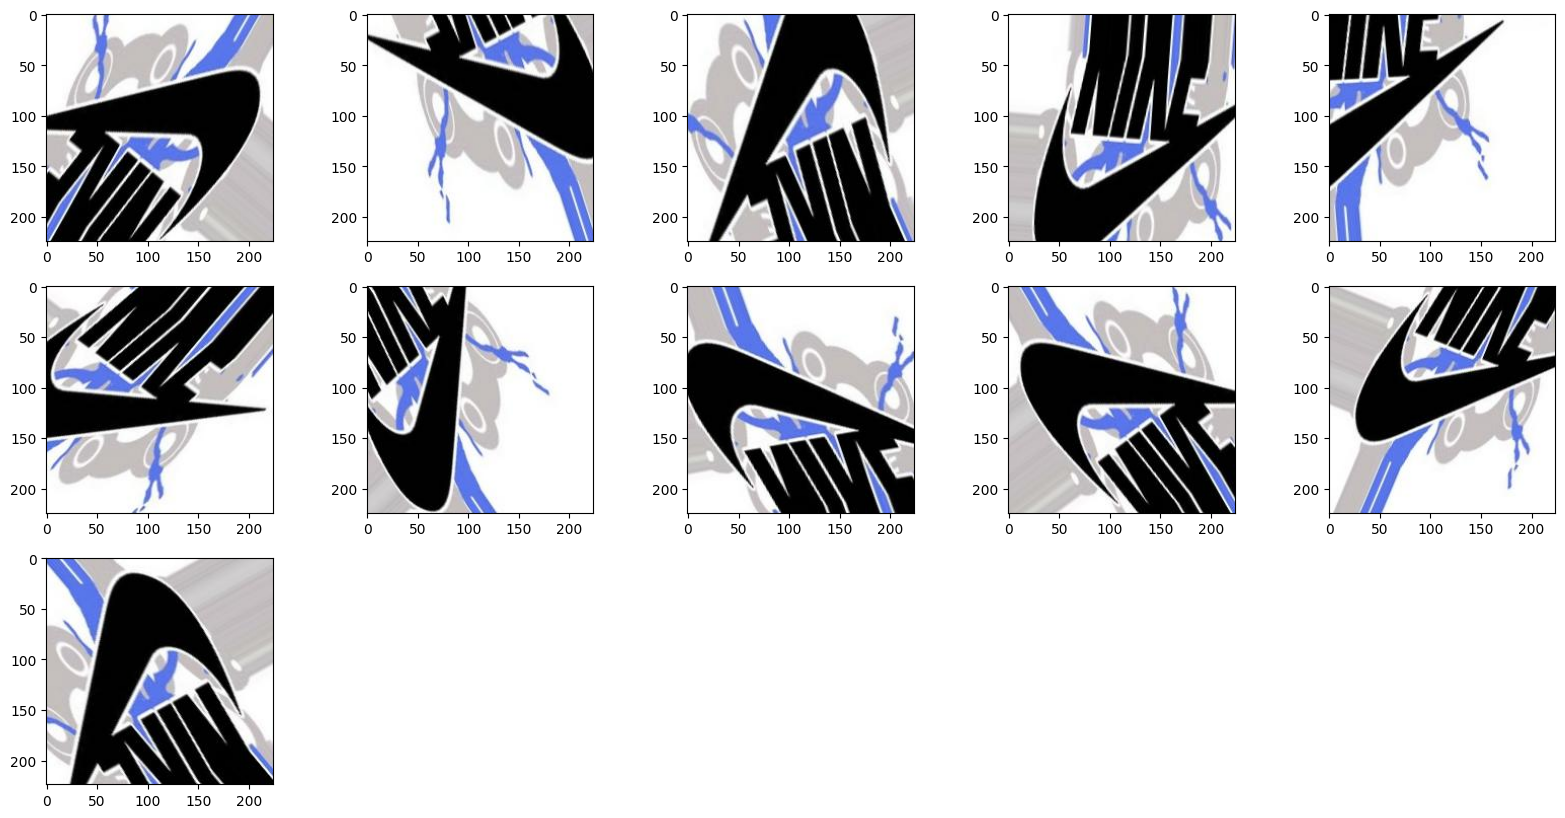

In [44]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('preview/*.jpeg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [45]:
HEIGHT = 224
WIDTH = 224
INIT_LR = 1e-4
EPOCHS =  100
BS = 256

## Splitting into Train and Validation Set

In [46]:
trainset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'training',
class_mode='categorical')

Found 648 images belonging to 27 classes.


In [47]:
validset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'validation',
class_mode='categorical')

Found 161 images belonging to 27 classes.


In [48]:
imagePaths = list(paths.list_images(dest))

In [49]:
#trainset.filenames

In [50]:
trainset.class_indices

{'Adidas': 0,
 'Apple': 1,
 'BMW': 2,
 'Citroen': 3,
 'Cocacola': 4,
 'DHL': 5,
 'Fedex': 6,
 'Ferrari': 7,
 'Ford': 8,
 'Google': 9,
 'HP': 10,
 'Heineken': 11,
 'Intel': 12,
 'McDonalds': 13,
 'Mini': 14,
 'Nbc': 15,
 'Nike': 16,
 'Pepsi': 17,
 'Porsche': 18,
 'Puma': 19,
 'RedBull': 20,
 'Sprite': 21,
 'Starbucks': 22,
 'Texaco': 23,
 'Unicef': 24,
 'Vodafone': 25,
 'Yahoo': 26}

## Model Architecture

In [51]:
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(trainset.num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["accuracy"])

83683744/83683744 [==============================] - 3s 0us/step
[INFO] compiling model...


In [52]:
totalTrain = len(list(paths.list_images(dest)))
totalTrain

809

## Train Results

In [53]:
H = model.fit_generator(
	trainset,
  validation_data = validset,
	epochs=EPOCHS)

<ipython-input-53-3c3e4bbb8f0b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/100
3/3 [==============================] - 26s 6s/step - loss: 3.6469 - accuracy: 0.0201 - val_loss: 3.0625 - val_accuracy: 0.1863
Epoch 2/100
3/3 [==============================] - 9s 3s/step - loss: 3.1878 - accuracy: 0.1019 - val_loss: 2.8907 - val_accuracy: 0.3540
Epoch 3/100
3/3 [==============================] - 9s 3s/step - loss: 2.9533 - accuracy: 0.1836 - val_loss: 2.7502 - val_accuracy: 0.3416
Epoch 4/100
3/3 [==============================] - 9s 4s/step - loss: 2.8200 - accuracy: 0.2176 - val_loss: 2.5227 - val_accuracy: 0.3913
Epoch 5/100
3/3 [==============================] - 9s 3s/step - loss: 2.6206 - accuracy: 0.2870 - val_loss: 2.3174 - val_accuracy: 0.4348
Epoch 6/100
3/3 [==============================] - 9s 4s/step - loss: 2.4160 - accuracy: 0.3549 - val_loss: 2.1280 - val_accuracy: 0.4969
Epoch 7/100
3/3 [==============================] - 9s 4s/step - loss: 2.2500 - accuracy: 0.3935 - val_loss: 1.9644 - val_accuracy: 0.5590
Epoch 8/100
3/3 [================

## Results Plot

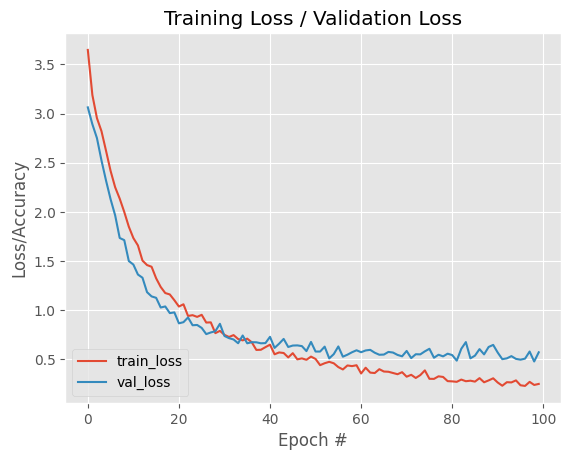

<Figure size 640x480 with 0 Axes>

In [68]:
# plot the training loss and accuracy
N = EPOCHS
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss / Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('graph.png')

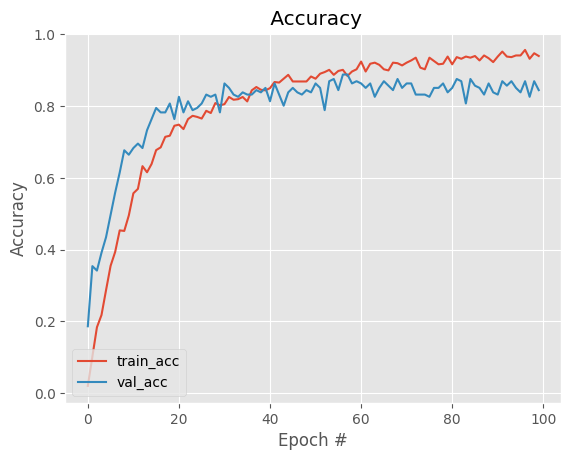

In [55]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

## F1-score Precision Recall

In [56]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
validset.reset()
predIdxs = model.predict(x=validset)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(validset.classes, predIdxs,
	target_names=validset.class_indices.keys()))
# serialize the model to disk
print("[INFO] serializing network...")
model.save('logo.model', save_format="h5")

[INFO] evaluating after fine-tuning network...


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

      Adidas       0.75      0.50      0.60         6
       Apple       1.00      0.83      0.91         6
         BMW       1.00      0.83      0.91         6
     Citroen       1.00      0.83      0.91         6
    Cocacola       0.67      1.00      0.80         6
         DHL       0.83      0.83      0.83         6
       Fedex       1.00      1.00      1.00         6
     Ferrari       1.00      1.00      1.00         6
        Ford       0.71      0.83      0.77         6
      Google       1.00      1.00      1.00         6
          HP       0.71      0.83      0.77         6
    Heineken       1.00      0.50      0.67         6
       Intel       0.57      0.67      0.62         6
   McDonalds       0.80      0.67      0.73         6
        Mini       0.75      1.00      0.86         6
         Nbc       1.00      1.00      1.00         6
        Nike       0.56      0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Some Prdictions from Test Set

In [57]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

In [58]:
model.get_config

<bound method Functional.get_config of <keras.src.engine.functional.Functional object at 0x7a24db517ac0>>

In [59]:
from PIL import Image
def predimage(path):
    image = Image.open(path)
    plt.imshow(image)
    test = load_img(path,target_size=(WIDTH,HEIGHT))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=-1)
    result = (result*100)
    result = list(np.around(np.array(result),1))
    print(result)
    print(y[y_class[0]])
    return y[y_class[0]]

def predimage_frame(frame):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.imshow(image)

    test = cv2.resize(frame, (WIDTH, HEIGHT))  # Assuming WIDTH and HEIGHT are defined
    test = test.astype("float") / 255.0

    test = np.expand_dims(test, axis=0)

    result = model.predict(test, batch_size=BS)
    y_class = result.argmax(axis=-1)

    result = (result * 100).tolist()[0]
    return y[y_class[0]], result

1/1 [==============================] - 1s 1s/step
[array([ 1.2,  1.1,  0.1,  0.7,  1. ,  3.7,  0.2,  0.9,  1.2,  1.1, 16. ,
        0.6,  0.6,  0.8,  1.1,  1.4, 57.3,  0.2,  0.2,  4.8,  2.3,  0.3,
        0.1,  0.3,  1.4,  0.4,  1.2], dtype=float32)]
Nike


'Nike'

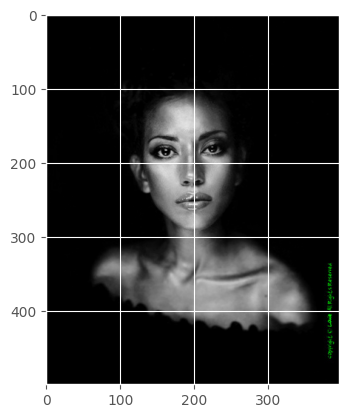

In [60]:
predimage(testimage[56])

1/1 [==============================] - 0s 22ms/step
[array([ 0. ,  0. ,  0. ,  0. , 97.1,  0. ,  0. ,  0. ,  0.4,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ,  0.2,  1.3,
        0. ,  0. ,  0.2,  0.3,  0.2], dtype=float32)]
Cocacola


'Cocacola'

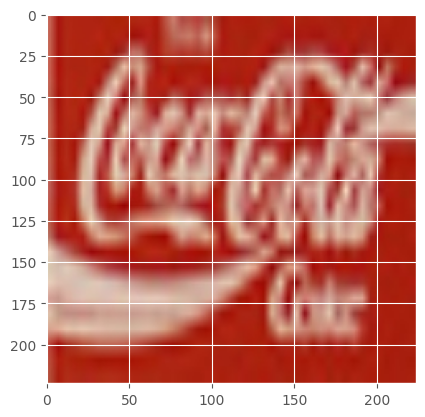

In [61]:
predimage(imagePaths[2])

1/1 [==============================] - 0s 23ms/step
[array([ 1.4,  1.9,  0.3,  0.1,  0.2,  0.1,  0.1,  0.1,  0.1,  1.2,  0. ,
        0.2,  0.2,  2.3,  0. , 87.7,  0.5,  0.8,  0.1,  0.1,  1.3,  0.2,
        0.1,  0.6,  0.2,  0.2,  0. ], dtype=float32)]
Nbc


'Nbc'

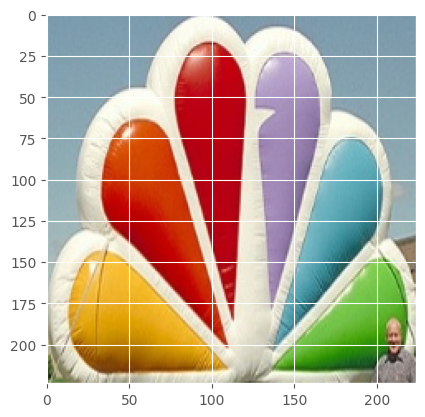

In [62]:
predimage(imagePaths[60])

1/1 [==============================] - 0s 24ms/step
[array([ 0.3,  0.4,  0.3,  0.1, 42.4,  1.2,  2. ,  0.4,  1.1,  0.2,  0.1,
        0.6,  1.8,  2.1,  0.5,  1. ,  1.3,  7.1,  0.1,  0.1,  0.6, 29.5,
        0.5,  2.6,  3.4,  0.4,  0.2], dtype=float32)]
Cocacola


'Cocacola'

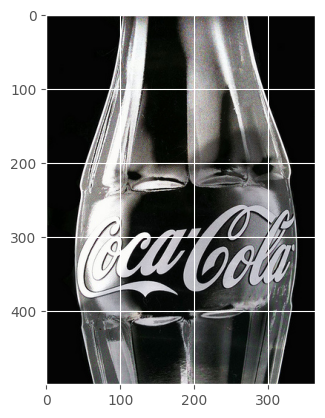

In [63]:
predimage(testimage[30])

1/1 [==============================] - 0s 22ms/step
[array([ 0.2,  0.1,  0.4,  0.1,  0.1,  0.2,  1.8,  0. ,  0.2,  0.1,  0.1,
        0.1,  3.1,  3.2,  0.1,  2.9,  0.1, 76.4,  0. ,  0.2,  0.1,  0.2,
        0. ,  0.8,  5. ,  3.9,  0.5], dtype=float32)]
Pepsi


'Pepsi'

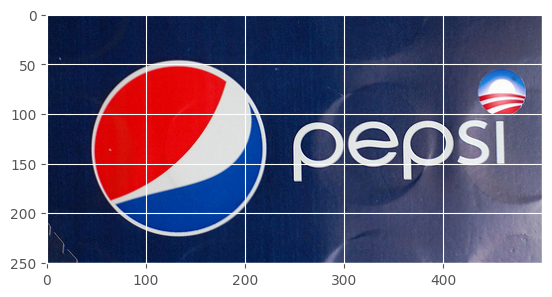

In [64]:
predimage(testimage[18])

1/1 [==============================] - 0s 22ms/step
[array([ 0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0.7,  0. ,  0. ,  0.1,  0. ,
        0.6,  0.7, 11.8,  0. ,  0.1,  0. , 21.6,  0. ,  0. ,  0.1,  0. ,
        0. ,  0.8,  0. , 61.3,  1.5], dtype=float32)]
Vodafone


'Vodafone'

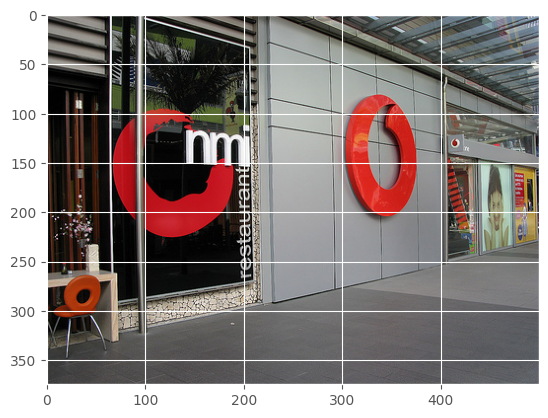

In [65]:
predimage(testimage[25])

In [71]:
!pip install pytube -qqq
from pytube import YouTube

def download_youtube_video(url, output_path):
    yt = YouTube(url)
    stream = yt.streams.filter(file_extension='mp4').first()
    stream.download(output_path)
    return stream.default_filename

def read_video_frames(video_path, target_class):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        label, predictions = predimage_frame(frame)
        confidence = np.max(predictions)

        time_seconds = frame_count / fps

        if confidence >= 95 and label == target_class:

            print(f"At {time_seconds:.2f} seconds - {label}, Confidence: {confidence:.2f}")

        frame_count += 1

video_url = "https://www.youtube.com/watch?v=UZZ5s_qhHMA"
output_path = "./"

video_filename = download_youtube_video(video_url, output_path)
read_video_frames(video_filename,  "Pepsi")

1/1 [==============================] - 0s 21ms/step
At 2.90 seconds - Pepsi, Confidence: 96.57
1/1 [==============================] - 0s 20ms/step
At 2.97 seconds - Pepsi, Confidence: 96.32
1/1 [==============================] - 0s 21ms/step
At 3.77 seconds - Pepsi, Confidence: 95.40
1/1 [==============================] - 0s 21ms/step
At 3.80 seconds - Pepsi, Confidence: 96.96
1/1 [==============================] - 0s 20ms/step
At 3.83 seconds - Pepsi, Confidence: 95.35
1/1 [==============================] - 0s 22ms/step
At 6.87 seconds - Pepsi, Confidence: 95.76
1/1 [==============================] - 0s 20ms/step
At 6.93 seconds - Pepsi, Confidence: 97.47
1/1 [==============================] - 0s 22ms/step
At 6.97 seconds - Pepsi, Confidence: 95.70
1/1 [==============================] - 0s 23ms/step
At 7.00 seconds - Pepsi, Confidence: 96.94
1/1 [==============================] - 0s 20ms/step
Error in callback <function flush_figures at 0x7a259571c3a0> (for post_execute):


KeyboardInterrupt: 